In [2]:
'''
Load the necessary libraries
'''

from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.graph_objs import *
import plotly.express as px
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

import hdbscan

import os
import glob

from sklearn.neighbors import NearestNeighbors
from numpy import linalg as LA
import numpy as np
import pandas as pd

Problematic dataset: 38

In [81]:
df = pd.read_pickle("../id_52.centroids_embedding_nuclei_covd.pkl")
df = df.sample(n=200000)
embedding = df[['x','y','z']].to_numpy()

In [13]:
'''Visualize the cloud'''
fig = px.scatter_3d(df, x="x", y="y", z="z")
fig.update_traces(marker=dict(size=1,opacity=0.5),selector=dict(mode='markers'))
fig.write_html('nuclei-covd-embedding.html', auto_open=True)

In [82]:
'''
Calculate the local curvature of the point cloud embedding
'''
# Find the neighborood
n_neighbors = 100 # parameter to be adjausted

nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree').fit(embedding)
distances, indices = nbrs.kneighbors(embedding)
eigvals = [LA.eigvalsh(np.cov(embedding[indices[idx,:],:].T)) for idx in range(embedding.shape[0])] #full data

curvatures = [min(eigvals[idx])/sum(eigvals[idx]) for idx in range(len(eigvals))]

# Add curvature to the dataframe
df['curvature'] = curvatures 

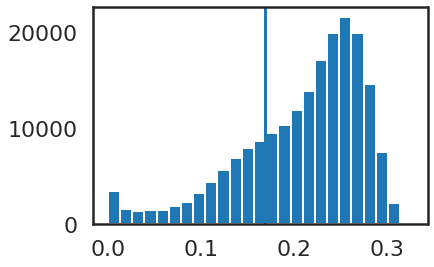

In [83]:
# Find the minima in curvature histrogram
q1 = np.quantile(curvatures,0.25)

plt.hist(curvatures,bins=25)
plt.axvline(q1,0,7500)
plt.show()

The mean intensity seems the quantity with the highest discriminative power.

In [23]:
for feature in df.columns[5:11]:
    df['color'] = pd.qcut(df[feature], 10, labels=False)
    fig = px.scatter_3d(df, x="x", y="y", z="z", color="color")
    fig.update_traces(marker=dict(size=1,opacity=0.5),selector=dict(mode='markers'))
    fig.update_layout(title=feature,
                      font=dict(family="Courier New, monospace",
                                size=18,
                                color="#7f7f7f")
                         )
    fig.write_html('test.'+feature+'.3Dumap.html', auto_open=True)

In [84]:
df['color'] = pd.qcut(df['curvature'], 10, labels=False)
df1 = df[df['curvature'] <= q1] # define the low curvature sector

In [16]:
fig = px.scatter_3d(df1, x="x", y="y", z="z", color="color")
fig.update_traces(marker=dict(size=1,opacity=0.5),selector=dict(mode='markers'))
fig.update_layout(title='Curvature values in the first quartile',
                            font=dict(
                            family="Courier New, monospace",
                            size=18,
                            color="#7f7f7f"
                                )
                     )
fig.write_html('test.curvature_q1.3Dumap.html', auto_open=True)

/home/garner1/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/garner1/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



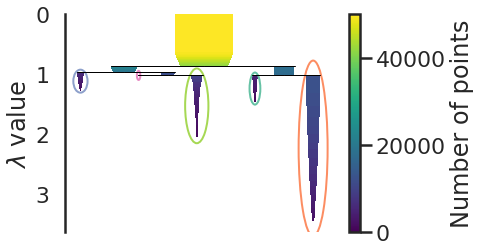

In [85]:
min_cluster_size = 1000 # parameter to be adjausted
min_samples = 500       # parameter to be adjausted
    
clusterer = hdbscan.HDBSCAN(min_samples=min_samples,min_cluster_size=min_cluster_size,gen_min_span_tree=True)
clusterer.fit(df1.loc[:,('x','y','z')]) 

clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette("Set2",len(clusterer.labels_)))
    
df1['cluster'] = clusterer.labels_    # add cluster id to dataframe
df1['cluster'] = df1['cluster'].apply(str)   # make cluster id a string
df_filtered = df1[df1.cluster != str(-1)] # remove unassigned points
    
fig = px.scatter(df_filtered, x="cx", y="cy",color="cluster",
                     width=800, height=800,
                     color_discrete_sequence=px.colors.qualitative.Set2)
fig.update_traces(marker=dict(size=5,opacity=1.0))
fig.write_html('spatial_decoration.html', auto_open=True)
    
fig = px.scatter_3d(df_filtered, x="x", y="y", z="z", color="cluster", hover_name="cluster", 
                        color_discrete_sequence=px.colors.qualitative.Set2)
fig.update_traces(marker=dict(size=3,opacity=0.75),selector=dict(mode='markers'))
fig.write_html('low_curvature_clusters.html', auto_open=True)

Thinking of the pipeline as a tool we should aim at simplifying the visualization and adjusting the parameters in order for the user to tune the output to his need. 

In [113]:
# partition curvatures into quantiles
numb_quantiles =  10 # parameter to be adjausted
df['curvature_quantile'] = pd.qcut(curvatures,numb_quantiles, retbins=False, labels=False)
#df['curvature_quantile'] = df['curvature_quantile'].apply(str)   #make clustet id a string

# There is now direct correlation between curvature and morphological features, 
# but curvature can still be used to segment the manifold

#plt.scatter(df['area'], df['curvature'],s=1)
#plt.show()

min_cluster_size = 500 # parameter to be adjausted
min_samples = 50       # parameter to be adjausted
for q in range(numb_quantiles)[:]:
    df_quantile = df[df['curvature_quantile']==q]
    # Cluster the curvature's quantile of the point cloud

    clusterer = hdbscan.HDBSCAN(min_samples=min_samples, 
                                min_cluster_size=min_cluster_size, 
                                gen_min_span_tree=True)
    clusterer.fit(df_quantile.loc[:,('x','y','z')]) 

#    clusterer.condensed_tree_.plot(select_clusters=True,selection_palette=sns.color_palette("Set2",len(clusterer.labels_)))
    
    df_quantile['cluster'] = clusterer.labels_    # add cluster id to dataframe
    df_quantile['cluster'] = df_quantile['cluster'].apply(str)   # make cluster id a string
    df_filtered = df_quantile[df_quantile.cluster != str(-1)] # remove unassigned points

    
    fig = px.scatter(df_filtered, x="cx", y="cy",color="cluster",width=800, height=800)
    fig.update_traces(marker=dict(size=5,opacity=1),selector=dict(mode='markers'))
    
#    fig = px.scatter_3d(df_filtered, x="x", y="y", z="z", color="cluster", hover_name="cluster", 
#                        color_discrete_sequence=px.colors.qualitative.Set2)
#    fig.update_traces(marker=dict(size=1,opacity=0.75),selector=dict(mode='markers'))

    fig.write_html('test.html', auto_open=True)

In [33]:
'''
UMAP representation of the morphology
'''
df_embedding['curvature'] = pd.qcut(curvatures,10, retbins=False, labels=False)

fig = px.scatter_3d(df_embedding[df_embedding['curvature']==9], 
                    x="x", y="y", z="z", 
                    color="curvature", 
                    hover_name="curvature", 
                    color_discrete_sequence=px.colors.qualitative.Set2)

fig.update_traces(marker=dict(size=1,opacity=0.5),selector=dict(mode='markers'))

fig.write_html('test.html', auto_open=True)

In [225]:
if len(minima) == 2:
    df1 = df[df['curvature'] < minima[0]]
    df2 = df[(minima[0] <= df['curvature']) & (df['curvature'] < minima[1])]
    df3 = df[minima[1] <= df['curvature']]
if len(minima) == 1:
    df1 = df[df['curvature'] < minima[0]]
    df2 = df[minima[0] <= df['curvature']]